In [1]:
from os.path import exists 
import pandas as pd
import shap
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

from utils.data_preparation import *
from utils.data_exploration import *
from utils.training import *


task = "cyp2c19"

In [2]:
pd.read_csv(f"optimization/{task}/best.csv", comment="#").sort_values("val_mcc", ascending=False)

,model,val_accuracy,val_f1,val_mcc,false_negative_rate,false_positive_rate
0,SVC,0.83,0.82,0.66,0.14,0.20
5,XGBoost_1,0.82,0.82,0.65,0.13,0.22
1,RandomForest,0.82,0.80,0.64,0.19,0.19
2,LogisticRegression,0.81,0.80,0.63,0.17,0.21
3,CatBoost,0.82,0.82,0.63,0.10,0.26
4,KNN,0.77,0.73,0.54,0.31,0.16


# Data

In [3]:
# load thedataset
data = data_preprocessing(task)

# we only use Morgan fingerprints
data = data.drop(["MACCS_FP", "ATOMPAIR_FP"], axis=1)

# druglike molecules
data = select_druglike_molecules(data)

# turn string of fingerprints into single features
morgan_fingerprint_df = pd.DataFrame(
    convert_strings_to_int_array(data["Morgan_FP"].values), index=data.index
)
data = data.merge(morgan_fingerprint_df, left_index=True, right_index=True)

# remove NaN values
data_nan = extract_null(data)
data = data.drop(data_nan.index)

display(data)

# split data in train, val, test
datasets = dataset_split(data.drop(["Drug", "Drug_ID", "Morgan_FP"], axis=1))
# The descriptors include discrete and continuous data, distinguished by their dtype.
feature_groups = get_feature_groups(datasets, morgan_fingerprint_df)

Dataset already exists, returning data/cyp2c19/raw_dataset.csv.
Number of molecules before druglikeliness selection: 12665
Number of druglike molecules: 12210


,Y,Drug,Drug_ID,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1,6602638.0,11.609395,0.039701,11.609395,0.039701,0.906872,309.841,285.649,...,0,0,0,0,0,0,0,0,0,0
1,1,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,644675.0,12.610408,-3.973681,12.610408,0.072387,0.720977,355.418,346.346,...,0,0,0,0,0,0,0,0,0,0
2,1,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,644851.0,6.126257,0.660427,6.126257,0.660427,0.756902,255.708,245.628,...,0,0,0,0,0,0,0,0,0,0
3,1,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,644890.0,5.719940,-0.219974,5.719940,0.075509,0.605920,421.549,390.301,...,0,0,0,0,0,0,0,0,0,0
4,1,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,644968.0,12.040635,-0.208718,12.040635,0.006714,0.728361,324.344,308.216,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12660,0,CCN1C(=O)[C@@H]2[C@@H](CC[C@@H]3C(=O)C=C[C@@H]...,16758814.0,12.346902,-0.801800,12.346902,0.024123,0.682518,263.293,246.157,...,0,0,0,0,0,0,0,0,0,0
12661,0,O=C1[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@H]4C3...,16758816.0,13.390757,-1.019880,13.390757,0.162294,0.455270,397.427,374.243,...,0,0,0,0,0,0,0,0,0,0
12662,1,CCN1C(=O)[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@...,16758817.0,12.817440,-0.985371,12.817440,0.131139,0.406549,335.356,314.188,...,0,0,0,0,0,0,0,0,0,0
12663,0,C[C@H](c1ccccc1)N1C(=O)[C@@H]2[C@@H](CC[C@@H]3...,16758818.0,13.179767,-1.161112,13.179767,0.077392,0.772281,357.406,334.222,...,0,0,0,0,0,0,0,0,0,0


Splitting the data into 70.00% training, 10.00% validation, and 20.00% testing.
Unique Datatypes: {dtype('int64'), dtype('float64')}


# SVC

In [4]:
file_loc = f"optimization/{task}/xgboost_0.csv"

# print comments
comments = ""
with open(file_loc, "r") as f:
    for line in f:
        if line[0] == "#":
            comments+=line

print(comments)

# print hyperparameter optimization results
pd.read_csv(file_loc, comment="#").drop("Unnamed: 0", axis=1).sort_values("val_mcc", ascending=False).head()

# fix_model_params={'objective': 'binary:logistic', 'eval_metric': 'aucpr'}
# main_metric=mcc
# model_params=[Real(low=0.01, high=1.0, prior='uniform', transform='identity'), Integer(low=100, high=10000, prior='uniform', transform='identity'), Integer(low=128, high=1024, prior='uniform', transform='identity'), Integer(low=5, high=50, prior='uniform', transform='identity'), Real(low=0.01, high=0.2, prior='uniform', transform='identity'), Real(low=0.5, high=1, prior='uniform', transform='identity'), Real(low=1, high=10, prior='uniform', transform='identity'), Real(low=0.5, high=1.0, prior='uniform', transform='identity'), Real(low=0.5, high=4.0, prior='uniform', transform='identity')]
# preprocessing_params=None



,learning_rate,n_estimators,max_bin,max_depth,eta,subsample,scale_pos_weight,colsample_bytree,lambda,var_threshold_continuous,var_threshold_discrete,var_threshold_fingerprint,corr_threshold,val_accuracy,val_f1,val_precision,val_recall,val_mcc,val_roc_auc_score,val_average_precision_score
8,0.062604,577,433,22,0.119645,0.889377,1.291588,0.591792,3.173205,0.039588,0.030471,0.038778,0.805977,0.821018,0.809441,0.796902,0.822380,0.641071,0.896766,0.871010
4,0.312102,515,247,24,0.180283,0.963464,3.307395,0.989206,1.311548,0.002686,0.000943,0.038828,0.860211,0.811166,0.800693,0.781726,0.820604,0.622148,0.890719,0.860737
7,0.278638,4181,795,9,0.163482,0.840500,5.476952,0.666111,2.897798,0.039675,0.009080,0.031522,0.860933,0.809524,0.801709,0.772652,0.833037,0.620576,0.878766,0.837521
0,0.625930,1104,626,17,0.171563,0.757073,1.228872,0.652089,1.204652,0.004512,0.008986,0.000495,0.989451,0.792282,0.777875,0.769097,0.786856,0.582991,0.866862,0.831103
2,0.533322,8743,872,15,0.091339,0.945769,3.493757,0.513087,1.577549,0.038833,0.038040,0.017271,0.888665,0.791461,0.780277,0.760540,0.801066,0.582804,0.868148,0.829444


In [5]:
model = SVC(
    C=1.306832, 
    class_weight="balanced"
)

data_prep = DataPreprocessing(
    feature_groups,
    var_threshold={
        "continuous": 0.016017,
        "discrete": 0.027299,
        "fingerprint": 0.002842,
    },
    corr_threshold=0.972394,
)


data_prep.fit(datasets["train"].drop("Y", axis=1), datasets["train"]["Y"])
x_train_prep = data_prep.transform(datasets["train"].drop("Y", axis=1))
x_val_prep = data_prep.transform(datasets["val"].drop("Y", axis=1))
x_test_prep = data_prep.transform(datasets["test"].drop("Y", axis=1))

model.fit(x_train_prep, datasets["train"]["Y"])

SVC(C=1.306832, class_weight='balanced')

Accuracy: 82.68%
F1-score: 82.07%
Matthews correlation coefficient: 0.6560467308514514%


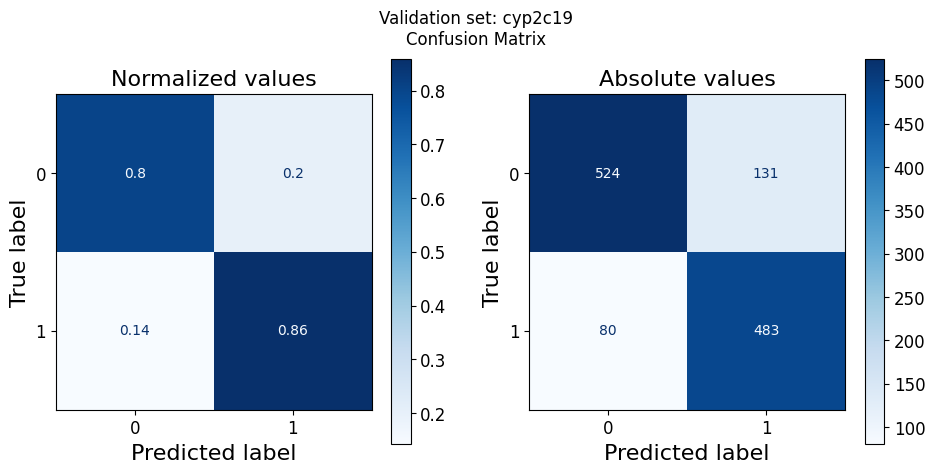

Accuracy: 83.49%
F1-score: 83.24%
Matthews correlation coefficient: 0.6712007027478665%


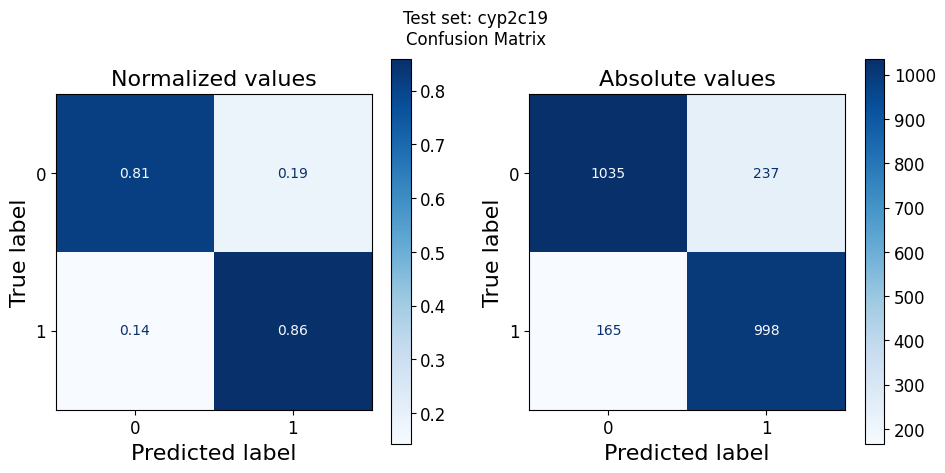

In [6]:
y_val_pred = model.predict(x_val_prep)
conf_matrix(datasets["val"]["Y"], y_val_pred, f"Validation set: {task}")

y_test_pred = model.predict(x_test_prep)
conf_matrix(datasets["test"]["Y"], y_test_pred, f"Test set: {task}")